In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/home/suriya/dcu/Group-Project


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

# Feature Importance Plots

## 1. Baseline

In [145]:
from src.dataset.tc4tl import make_datasets
from src.features.gomez import features, postproc
from src.features.common import postproc_categorical

import category_encoders as ce


(trainset, devset, testset), pipe = make_datasets(features, postproc_categorical, verbose=True, testing=0,
                                     tunables={
                                         "cg=Y" : {
                                             "TX" : -52,
                                             "N"  : 2.6
                                         },
                                         "cg=N" : {
                                             "TX" : -54,
                                             "N" : 2.1
                                         },
                                        "CategoricalEncoder" : ce.ordinal.OrdinalEncoder
                                     })

100%|████████████████████████████████████| 15552/15552 [00:44<00:00, 350.02it/s]


NO Pipe input given!


100%|████████████████████████████████████████| 935/935 [00:02<00:00, 383.38it/s]


Pipe input given!


100%|██████████████████████████████████████| 8423/8423 [00:20<00:00, 420.39it/s]

Pipe input given!


In [9]:
trainset.columns
predictors = []
for col in trainset.columns:
    if "Cat:" in col or "Num:" in col:
        predictors.append(col)
predictors

['Cat:TXDevice',
 'Cat:TXPower',
 'Cat:RXDevice',
 'Cat:TXCarry',
 'Cat:RXCarry',
 'Cat:RXPose',
 'Cat:TXPose',
 'Num:PredictedDistance',
 'Num:MeanRssi',
 'Num:PathLossAttenuation']

In [12]:
from src.models.evaluate import dual_evaluation
from sklearn.ensemble import GradientBoostingClassifier
from src.ndcf import compute_ndcf

gbm = GradientBoostingClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors,
                   target="Distance", model=gbm)
ndcf = {}
ndcf["gomez_full"] = compute_ndcf(sysout).nDCF.mean()

### Calculate Feature importance

In [40]:
fi = gbm.feature_importances_
sorted_indices = np.argsort(fi)#[::-1]

Text(0.5, 1.0, 'Importance of Gomez et al Features')

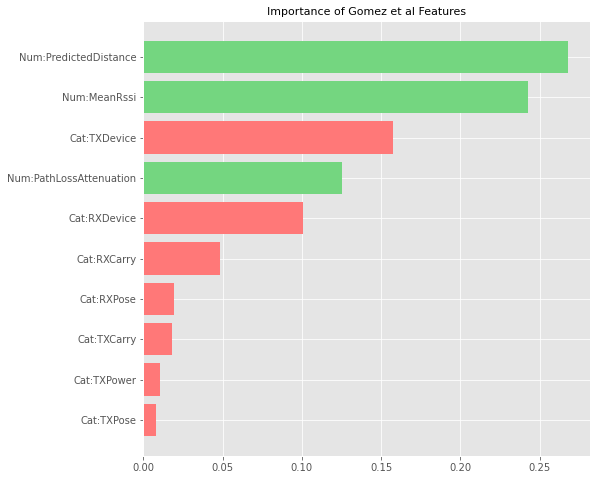

In [69]:
plt.figure(figsize=(8, 8))
feature_names_sorted = np.array(predictors)[sorted_indices]
cols = ["#74d680" if "Num:" in f else "#ff7878" for f in feature_names_sorted]
plt.barh(feature_names_sorted, fi[sorted_indices], color=cols)
plt.title("Importance of Gomez et al Features", fontsize=11)


## 1.2 Without Categorical Features

In [59]:
predictors_wo_cat = [c for c in predictors if "Cat:" not in c ]
gbm = GradientBoostingClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, 
                                 predictors=predictors_wo_cat,
                                 target="Distance", model=gbm)
ndcf["gomez_wo_cat"] = compute_ndcf(sysout).nDCF.mean()

In [60]:
ndcf

{'gomez_full': 0.520558560293825, 'gomez_wo_cat': 0.6362740618533063}

## 1.3 Without Predicted Distance

In [70]:
predictors_wo_cat = [c for c in predictors if "Distance" not in c ]
gbm = GradientBoostingClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, 
                                 predictors=predictors_wo_cat,
                                 target="Distance", model=gbm)
ndcf["gomez_wo_pred_distance"] = compute_ndcf(sysout).nDCF.mean()

In [71]:
ndcf

{'gomez_full': 0.520558560293825,
 'gomez_wo_cat': 0.6362740618533063,
 'gomez_wo_pred_distance': 0.5206785205903943}

In [72]:
predictors_wo_cat

['Cat:TXDevice',
 'Cat:TXPower',
 'Cat:RXDevice',
 'Cat:TXCarry',
 'Cat:RXCarry',
 'Cat:RXPose',
 'Cat:TXPose',
 'Num:MeanRssi',
 'Num:PathLossAttenuation']

## 1.4 Without Path Loss Attenuation

In [73]:
predictors_wo = [c for c in predictors if "Distance" not in c and "Attenuation" not in c]
print(predictors_wo)
gbm = GradientBoostingClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, 
                                 predictors=predictors_wo,
                                 target="Distance", model=gbm)
ndcf["gomez_wo_pred_distance_|_pla"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice', 'Cat:TXPower', 'Cat:RXDevice', 'Cat:TXCarry', 'Cat:RXCarry', 'Cat:RXPose', 'Cat:TXPose', 'Num:MeanRssi']


{'gomez_full': 0.520558560293825,
 'gomez_wo_cat': 0.6362740618533063,
 'gomez_wo_pred_distance': 0.5206785205903943,
 'gomez_wo_pred_distance_|_pla': 0.5249836893402402}

## 1.5 Without RSSI

In [80]:
predictors

['Cat:TXDevice',
 'Cat:TXPower',
 'Cat:RXDevice',
 'Cat:TXCarry',
 'Cat:RXCarry',
 'Cat:RXPose',
 'Cat:TXPose',
 'Num:PredictedDistance',
 'Num:MeanRssi',
 'Num:PathLossAttenuation']

In [82]:
predictors_wo = [c for c in predictors if "rssi" not in c.lower() and "Distance" not in c]
print(predictors_wo)
gbm = GradientBoostingClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, 
                                 predictors=predictors_wo,
                                 target="Distance", model=gbm)
ndcf["gomez_wo_rssi_|_pred_distance"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice', 'Cat:TXPower', 'Cat:RXDevice', 'Cat:TXCarry', 'Cat:RXCarry', 'Cat:RXPose', 'Cat:TXPose', 'Num:PathLossAttenuation']


{'gomez_full': 0.520558560293825,
 'gomez_wo_cat': 0.6362740618533063,
 'gomez_wo_pred_distance': 0.5206785205903943,
 'gomez_wo_pred_distance_|_pla': 0.5249836893402402,
 'gomez_wo_rssi': 0.5207381579949744,
 'gomez_wo_rssi_|_pred_distance': 0.5091850423170209}

In [84]:
predictors_wo = [c for c in predictors if "rssi" not in c.lower() and "PathLoss" not in c]
print(predictors_wo)
gbm = GradientBoostingClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, 
                                 predictors=predictors_wo,
                                 target="Distance", model=gbm)
ndcf["gomez_wo_rssi_|_pla"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice', 'Cat:TXPower', 'Cat:RXDevice', 'Cat:TXCarry', 'Cat:RXCarry', 'Cat:RXPose', 'Cat:TXPose', 'Num:PredictedDistance']


{'gomez_full': 0.520558560293825,
 'gomez_wo_cat': 0.6362740618533063,
 'gomez_wo_pred_distance': 0.5206785205903943,
 'gomez_wo_pred_distance_|_pla': 0.5249836893402402,
 'gomez_wo_rssi': 0.5207381579949744,
 'gomez_wo_rssi_|_pred_distance': 0.5091850423170209,
 'gomez_wo_rssi_|_pla': 0.5249836893402402}

## 1.6 Without PLA

In [91]:
predictors_wo = [c for c in predictors if "PathLoss" not in c]
print(predictors_wo)
gbm = GradientBoostingClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, 
                                 predictors=predictors_wo,
                                 target="Distance", model=gbm)
ndcf["gomez_wo_pla"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice', 'Cat:TXPower', 'Cat:RXDevice', 'Cat:TXCarry', 'Cat:RXCarry', 'Cat:RXPose', 'Cat:TXPose', 'Num:PredictedDistance', 'Num:MeanRssi']


{'gomez_full': 0.520558560293825,
 'gomez_wo_cat': 0.6362740618533063,
 'gomez_wo_pred_distance': 0.5206785205903943,
 'gomez_wo_pred_distance_|_pla': 0.5249836893402402,
 'gomez_wo_rssi': 0.5207381579949744,
 'gomez_wo_rssi_|_pred_distance': 0.5091850423170209,
 'gomez_wo_rssi_|_pla': 0.5249836893402402,
 'gomez_wo_pla': 0.5249836893402402}

In [146]:
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, 
                                 predictors=predictors,
                                 target="Distance", seed=15)
ndcf["gomez_random_forest"] = compute_ndcf(sysout).nDCF.mean()
ndcf

{'gomez_full': 0.520558560293825,
 'gomez_wo_cat': 0.6362740618533063,
 'gomez_wo_pred_distance': 0.5206785205903943,
 'gomez_wo_pred_distance_|_pla': 0.5249836893402402,
 'gomez_wo_rssi': 0.5207381579949744,
 'gomez_wo_rssi_|_pred_distance': 0.5091850423170209,
 'gomez_wo_rssi_|_pla': 0.5249836893402402,
 'gomez_wo_pla': 0.5249836893402402,
 'gomez_random_forest': 0.4757273967200968}

## 1.5 Gomez et al Ablation plot

In [147]:
from collections import OrderedDict

names = OrderedDict({
    "gomez_full" : "Full",
    "gomez_wo_cat" : "Categorical Features",
    "gomez_wo_rssi": "Bluetooth RSSI Mean",
    "gomez_wo_pred_distance" : "Predicted Distance",
    "gomez_wo_pla" : "Path Loss Attenuation", 
    "gomez_wo_rssi_|_pla" : "Bluetooth RSSI Mean & Path Loss Attenuation",
    "gomez_wo_rssi_|_pred_distance" : "Bluetooth RSSI Mean & Predicted Distance",
    "gomez_wo_pred_distance_|_pla" : "Path Loss Attenuation & Predicted Distance",
    "gomez_random_forest" : "All (Random Forest)"
})

Text(0.5, 0, 'ndcf score difference')

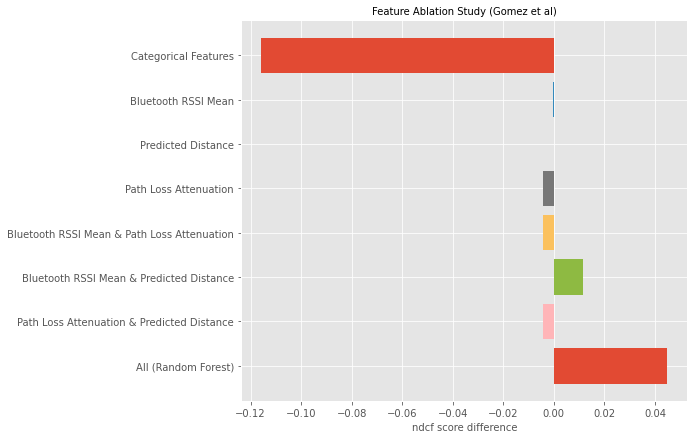

In [148]:
plt.figure(figsize=(8, 7))
for name, value in names.items():
    if value != "Full":
        diff = ndcf["gomez_full"]- ndcf[name]
        plt.barh(value, diff)
        # plt.xlim(-0.006, 0.015)
        # plt.text(0.0002, 0., str(diff)[:4], color='blue', fontweight='bold', fontdict=dict(fontsize=20))

plt.gca().invert_yaxis()
plt.title("Feature Ablation Study (Gomez et al)", fontsize=10)
plt.xlabel("ndcf score difference", fontsize=10)

## 2. Our Approach

### 2.1 Bluetooth Min, Mean, Max

In [150]:
from src.dataset.tc4tl import make_datasets
from src.features.beyond import sensor_summary
from src.features.common import postproc_categorical, read_non_sensor_data
from src.featutils import combine

import category_encoders as ce

(trainset, devset, testset), pipe = make_datasets(combine(sensor_summary, read_non_sensor_data), postproc_categorical,
                                     tunables={
                                         "CategoricalEncoder" : ce.polynomial.PolynomialEncoder
                                     }, verbose=True, testing=0)

100%|████████████████████████████████████| 15552/15552 [01:07<00:00, 229.45it/s]


NO Pipe input given!


100%|████████████████████████████████████████| 935/935 [00:03<00:00, 243.32it/s]


Pipe input given!


100%|██████████████████████████████████████| 8423/8423 [00:33<00:00, 253.37it/s]


Pipe input given!


In [156]:
predictors = []
for col in trainset.columns:
    if "Bluetooth" in col or ("Cat:" in col and "_" in col):
        predictors.append(col)
        
predictors

['Cat:TXDevice_0',
 'Cat:TXDevice_1',
 'Cat:TXDevice_2',
 'Cat:TXDevice_3',
 'Cat:TXDevice_4',
 'Cat:TXDevice_5',
 'Cat:TXDevice_6',
 'Cat:TXDevice_7',
 'Cat:TXDevice_8',
 'Cat:TXDevice_9',
 'Cat:TXDevice_10',
 'Cat:TXDevice_11',
 'Cat:TXDevice_12',
 'Cat:TXDevice_13',
 'Cat:TXPower_0',
 'Cat:TXPower_1',
 'Cat:RXDevice_0',
 'Cat:RXDevice_1',
 'Cat:RXDevice_2',
 'Cat:RXDevice_3',
 'Cat:RXDevice_4',
 'Cat:RXDevice_5',
 'Cat:RXDevice_6',
 'Cat:RXDevice_7',
 'Cat:RXDevice_8',
 'Cat:TXCarry_0',
 'Cat:RXCarry_0',
 'Cat:RXPose_0',
 'Cat:TXPose_0',
 'Bluetooth:Min',
 'Bluetooth:Percentile_1',
 'Bluetooth:Percentile_5',
 'Bluetooth:Percentile_10',
 'Bluetooth:Percentile_25',
 'Bluetooth:Percentile_40',
 'Bluetooth:Mean',
 'Bluetooth:Percentile_65',
 'Bluetooth:Percentile_80',
 'Bluetooth:Percentile_90',
 'Bluetooth:Percentile_95',
 'Bluetooth:Percentile_99',
 'Bluetooth:Max']

### 2.0 Bluetooth Min/Mean/Max

In [177]:
predictors = [ col for col in trainset.columns if "Bluetooth" in col and "_" not in col ]
print(predictors)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors,
                   target="Distance", seed=0)
ndcf = {}
ndcf["Bluetooth Min/Mean/Max"] = compute_ndcf(sysout).nDCF.mean()
ndcf


['Bluetooth:Min', 'Bluetooth:Mean', 'Bluetooth:Max']


{'Bluetooth Min/Mean/Max': 0.619762595765736}

### 2.1 Bluetooth Percentiles

In [178]:
predictors = [ col for col in trainset.columns if "Bluetooth" in col ]
print(predictors)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors,
                   target="Distance", seed=0)
ndcf["Bluetooth Percentiles & Min/Mean/Max"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Bluetooth:Min', 'Bluetooth:Percentile_1', 'Bluetooth:Percentile_5', 'Bluetooth:Percentile_10', 'Bluetooth:Percentile_25', 'Bluetooth:Percentile_40', 'Bluetooth:Mean', 'Bluetooth:Percentile_65', 'Bluetooth:Percentile_80', 'Bluetooth:Percentile_90', 'Bluetooth:Percentile_95', 'Bluetooth:Percentile_99', 'Bluetooth:Max']


{'Bluetooth Min/Mean/Max': 0.619762595765736,
 'Bluetooth Percentiles & Min/Mean/Max': 0.4728934256678541}

### 2.2 +Categorial Features

In [179]:
predictors = [ col for col in trainset.columns if "Bluetooth" in col or ("Cat:" in col and "_" in col) ]
print(predictors)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors,
                   target="Distance", seed=0)

ndcf["+Categorical Features"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice_0', 'Cat:TXDevice_1', 'Cat:TXDevice_2', 'Cat:TXDevice_3', 'Cat:TXDevice_4', 'Cat:TXDevice_5', 'Cat:TXDevice_6', 'Cat:TXDevice_7', 'Cat:TXDevice_8', 'Cat:TXDevice_9', 'Cat:TXDevice_10', 'Cat:TXDevice_11', 'Cat:TXDevice_12', 'Cat:TXDevice_13', 'Cat:TXPower_0', 'Cat:TXPower_1', 'Cat:RXDevice_0', 'Cat:RXDevice_1', 'Cat:RXDevice_2', 'Cat:RXDevice_3', 'Cat:RXDevice_4', 'Cat:RXDevice_5', 'Cat:RXDevice_6', 'Cat:RXDevice_7', 'Cat:RXDevice_8', 'Cat:TXCarry_0', 'Cat:RXCarry_0', 'Cat:RXPose_0', 'Cat:TXPose_0', 'Bluetooth:Min', 'Bluetooth:Percentile_1', 'Bluetooth:Percentile_5', 'Bluetooth:Percentile_10', 'Bluetooth:Percentile_25', 'Bluetooth:Percentile_40', 'Bluetooth:Mean', 'Bluetooth:Percentile_65', 'Bluetooth:Percentile_80', 'Bluetooth:Percentile_90', 'Bluetooth:Percentile_95', 'Bluetooth:Percentile_99', 'Bluetooth:Max']


{'Bluetooth Min/Mean/Max': 0.619762595765736,
 'Bluetooth Percentiles & Min/Mean/Max': 0.4728934256678541,
 '+Categorical Features': 0.22036800220371328}

### 2.3 +IMU Sensor Summaries

In [180]:
predictors = [ col for col in trainset.columns if "_" in col ]
print(predictors)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors,
                   target="Distance", seed=0)

ndcf["+IMU Sensor Summaries"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice_0', 'Cat:TXDevice_1', 'Cat:TXDevice_2', 'Cat:TXDevice_3', 'Cat:TXDevice_4', 'Cat:TXDevice_5', 'Cat:TXDevice_6', 'Cat:TXDevice_7', 'Cat:TXDevice_8', 'Cat:TXDevice_9', 'Cat:TXDevice_10', 'Cat:TXDevice_11', 'Cat:TXDevice_12', 'Cat:TXDevice_13', 'Cat:TXPower_0', 'Cat:TXPower_1', 'Cat:RXDevice_0', 'Cat:RXDevice_1', 'Cat:RXDevice_2', 'Cat:RXDevice_3', 'Cat:RXDevice_4', 'Cat:RXDevice_5', 'Cat:RXDevice_6', 'Cat:RXDevice_7', 'Cat:RXDevice_8', 'Cat:TXCarry_0', 'Cat:RXCarry_0', 'Cat:RXPose_0', 'Cat:TXPose_0', 'Bluetooth:Percentile_1', 'Bluetooth:Percentile_5', 'Bluetooth:Percentile_10', 'Bluetooth:Percentile_25', 'Bluetooth:Percentile_40', 'Bluetooth:Percentile_65', 'Bluetooth:Percentile_80', 'Bluetooth:Percentile_90', 'Bluetooth:Percentile_95', 'Bluetooth:Percentile_99', 'Accelerometer_x:Min', 'Accelerometer_x:Mean', 'Accelerometer_x:Max', 'Accelerometer_y:Min', 'Accelerometer_y:Mean', 'Accelerometer_y:Max', 'Accelerometer_z:Min', 'Accelerometer_z:Mean', 'Accelerometer_z:Max', 'Gy

{'Bluetooth Min/Mean/Max': 0.619762595765736,
 'Bluetooth Percentiles & Min/Mean/Max': 0.4728934256678541,
 '+Categorical Features': 0.22036800220371328,
 '+IMU Sensor Summaries': 0.08822264981663216}

### 2.4 Extra Trees Classifier

In [181]:
from sklearn.ensemble import ExtraTreesClassifier

predictors = [ col for col in trainset.columns if "_" in col ]
print(predictors)
et = ExtraTreesClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors,
                   target="Distance", model=et)

ndcf["Extra Trees Regressor"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice_0', 'Cat:TXDevice_1', 'Cat:TXDevice_2', 'Cat:TXDevice_3', 'Cat:TXDevice_4', 'Cat:TXDevice_5', 'Cat:TXDevice_6', 'Cat:TXDevice_7', 'Cat:TXDevice_8', 'Cat:TXDevice_9', 'Cat:TXDevice_10', 'Cat:TXDevice_11', 'Cat:TXDevice_12', 'Cat:TXDevice_13', 'Cat:TXPower_0', 'Cat:TXPower_1', 'Cat:RXDevice_0', 'Cat:RXDevice_1', 'Cat:RXDevice_2', 'Cat:RXDevice_3', 'Cat:RXDevice_4', 'Cat:RXDevice_5', 'Cat:RXDevice_6', 'Cat:RXDevice_7', 'Cat:RXDevice_8', 'Cat:TXCarry_0', 'Cat:RXCarry_0', 'Cat:RXPose_0', 'Cat:TXPose_0', 'Bluetooth:Percentile_1', 'Bluetooth:Percentile_5', 'Bluetooth:Percentile_10', 'Bluetooth:Percentile_25', 'Bluetooth:Percentile_40', 'Bluetooth:Percentile_65', 'Bluetooth:Percentile_80', 'Bluetooth:Percentile_90', 'Bluetooth:Percentile_95', 'Bluetooth:Percentile_99', 'Accelerometer_x:Min', 'Accelerometer_x:Mean', 'Accelerometer_x:Max', 'Accelerometer_y:Min', 'Accelerometer_y:Mean', 'Accelerometer_y:Max', 'Accelerometer_z:Min', 'Accelerometer_z:Mean', 'Accelerometer_z:Max', 'Gy

{'Bluetooth Min/Mean/Max': 0.619762595765736,
 'Bluetooth Percentiles & Min/Mean/Max': 0.4728934256678541,
 '+Categorical Features': 0.22036800220371328,
 '+IMU Sensor Summaries': 0.08822264981663216,
 'Extra Trees Regressor': 0.0741548757880778}

### 2.5 wo Bluetooth

In [185]:
from sklearn.ensemble import ExtraTreesClassifier

predictors_wo = [ col for col in trainset.columns if "_" in col and "Bluetooth" not in col ]
print(predictors_wo)
et = ExtraTreesClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors_wo,
                   target="Distance", model=et)

ndcf["-Bluetooth"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice_0', 'Cat:TXDevice_1', 'Cat:TXDevice_2', 'Cat:TXDevice_3', 'Cat:TXDevice_4', 'Cat:TXDevice_5', 'Cat:TXDevice_6', 'Cat:TXDevice_7', 'Cat:TXDevice_8', 'Cat:TXDevice_9', 'Cat:TXDevice_10', 'Cat:TXDevice_11', 'Cat:TXDevice_12', 'Cat:TXDevice_13', 'Cat:TXPower_0', 'Cat:TXPower_1', 'Cat:RXDevice_0', 'Cat:RXDevice_1', 'Cat:RXDevice_2', 'Cat:RXDevice_3', 'Cat:RXDevice_4', 'Cat:RXDevice_5', 'Cat:RXDevice_6', 'Cat:RXDevice_7', 'Cat:RXDevice_8', 'Cat:TXCarry_0', 'Cat:RXCarry_0', 'Cat:RXPose_0', 'Cat:TXPose_0', 'Accelerometer_x:Min', 'Accelerometer_x:Mean', 'Accelerometer_x:Max', 'Accelerometer_y:Min', 'Accelerometer_y:Mean', 'Accelerometer_y:Max', 'Accelerometer_z:Min', 'Accelerometer_z:Mean', 'Accelerometer_z:Max', 'Gyroscope_x:Min', 'Gyroscope_x:Mean', 'Gyroscope_x:Max', 'Gyroscope_y:Min', 'Gyroscope_y:Mean', 'Gyroscope_y:Max', 'Gyroscope_z:Min', 'Gyroscope_z:Mean', 'Gyroscope_z:Max', 'Attitude_x:Min', 'Attitude_x:Mean', 'Attitude_x:Max', 'Attitude_y:Min', 'Attitude_y:Mean', 'Atti

{'Bluetooth Min/Mean/Max': 0.619762595765736,
 'Bluetooth Percentiles & Min/Mean/Max': 0.4728934256678541,
 '+Categorical Features': 0.22036800220371328,
 '+IMU Sensor Summaries': 0.08822264981663216,
 'Extra Trees Regressor': 0.0741548757880778,
 '-Bluetooth': 0.0726848513919191}

### 2.6 wo Accelerometer

In [186]:
from sklearn.ensemble import ExtraTreesClassifier

predictors_wo = [ col for col in trainset.columns if "_" in col and "Accelerometer" not in col ]
print(predictors_wo)
et = ExtraTreesClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors_wo,
                   target="Distance", model=et)

ndcf["-Accelerometer"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice_0', 'Cat:TXDevice_1', 'Cat:TXDevice_2', 'Cat:TXDevice_3', 'Cat:TXDevice_4', 'Cat:TXDevice_5', 'Cat:TXDevice_6', 'Cat:TXDevice_7', 'Cat:TXDevice_8', 'Cat:TXDevice_9', 'Cat:TXDevice_10', 'Cat:TXDevice_11', 'Cat:TXDevice_12', 'Cat:TXDevice_13', 'Cat:TXPower_0', 'Cat:TXPower_1', 'Cat:RXDevice_0', 'Cat:RXDevice_1', 'Cat:RXDevice_2', 'Cat:RXDevice_3', 'Cat:RXDevice_4', 'Cat:RXDevice_5', 'Cat:RXDevice_6', 'Cat:RXDevice_7', 'Cat:RXDevice_8', 'Cat:TXCarry_0', 'Cat:RXCarry_0', 'Cat:RXPose_0', 'Cat:TXPose_0', 'Bluetooth:Percentile_1', 'Bluetooth:Percentile_5', 'Bluetooth:Percentile_10', 'Bluetooth:Percentile_25', 'Bluetooth:Percentile_40', 'Bluetooth:Percentile_65', 'Bluetooth:Percentile_80', 'Bluetooth:Percentile_90', 'Bluetooth:Percentile_95', 'Bluetooth:Percentile_99', 'Gyroscope_x:Min', 'Gyroscope_x:Mean', 'Gyroscope_x:Max', 'Gyroscope_y:Min', 'Gyroscope_y:Mean', 'Gyroscope_y:Max', 'Gyroscope_z:Min', 'Gyroscope_z:Mean', 'Gyroscope_z:Max', 'Attitude_x:Min', 'Attitude_x:Mean', 'A

{'Bluetooth Min/Mean/Max': 0.619762595765736,
 'Bluetooth Percentiles & Min/Mean/Max': 0.4728934256678541,
 '+Categorical Features': 0.22036800220371328,
 '+IMU Sensor Summaries': 0.08822264981663216,
 'Extra Trees Regressor': 0.0741548757880778,
 '-Bluetooth': 0.0726848513919191,
 '-Accelerometer': 0.07598071849208757}

### 2.7 wo Gyroscope

In [187]:
from sklearn.ensemble import ExtraTreesClassifier

predictors_wo = [ col for col in trainset.columns if "_" in col and "Gyroscope" not in col ]
print(predictors_wo)
et = ExtraTreesClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors_wo,
                   target="Distance", model=et)

ndcf["-Gyroscope"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice_0', 'Cat:TXDevice_1', 'Cat:TXDevice_2', 'Cat:TXDevice_3', 'Cat:TXDevice_4', 'Cat:TXDevice_5', 'Cat:TXDevice_6', 'Cat:TXDevice_7', 'Cat:TXDevice_8', 'Cat:TXDevice_9', 'Cat:TXDevice_10', 'Cat:TXDevice_11', 'Cat:TXDevice_12', 'Cat:TXDevice_13', 'Cat:TXPower_0', 'Cat:TXPower_1', 'Cat:RXDevice_0', 'Cat:RXDevice_1', 'Cat:RXDevice_2', 'Cat:RXDevice_3', 'Cat:RXDevice_4', 'Cat:RXDevice_5', 'Cat:RXDevice_6', 'Cat:RXDevice_7', 'Cat:RXDevice_8', 'Cat:TXCarry_0', 'Cat:RXCarry_0', 'Cat:RXPose_0', 'Cat:TXPose_0', 'Bluetooth:Percentile_1', 'Bluetooth:Percentile_5', 'Bluetooth:Percentile_10', 'Bluetooth:Percentile_25', 'Bluetooth:Percentile_40', 'Bluetooth:Percentile_65', 'Bluetooth:Percentile_80', 'Bluetooth:Percentile_90', 'Bluetooth:Percentile_95', 'Bluetooth:Percentile_99', 'Accelerometer_x:Min', 'Accelerometer_x:Mean', 'Accelerometer_x:Max', 'Accelerometer_y:Min', 'Accelerometer_y:Mean', 'Accelerometer_y:Max', 'Accelerometer_z:Min', 'Accelerometer_z:Mean', 'Accelerometer_z:Max', 'At

{'Bluetooth Min/Mean/Max': 0.619762595765736,
 'Bluetooth Percentiles & Min/Mean/Max': 0.4728934256678541,
 '+Categorical Features': 0.22036800220371328,
 '+IMU Sensor Summaries': 0.08822264981663216,
 'Extra Trees Regressor': 0.0741548757880778,
 '-Bluetooth': 0.0726848513919191,
 '-Accelerometer': 0.07598071849208757,
 '-Gyroscope': 0.07349310099794051}

### 2.8 wo Gravity

In [188]:
predictors_wo = [ col for col in trainset.columns if "_" in col and "Gravity" not in col ]
print(predictors_wo)
et = ExtraTreesClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors_wo,
                   target="Distance", model=et)

ndcf["-Gravity"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice_0', 'Cat:TXDevice_1', 'Cat:TXDevice_2', 'Cat:TXDevice_3', 'Cat:TXDevice_4', 'Cat:TXDevice_5', 'Cat:TXDevice_6', 'Cat:TXDevice_7', 'Cat:TXDevice_8', 'Cat:TXDevice_9', 'Cat:TXDevice_10', 'Cat:TXDevice_11', 'Cat:TXDevice_12', 'Cat:TXDevice_13', 'Cat:TXPower_0', 'Cat:TXPower_1', 'Cat:RXDevice_0', 'Cat:RXDevice_1', 'Cat:RXDevice_2', 'Cat:RXDevice_3', 'Cat:RXDevice_4', 'Cat:RXDevice_5', 'Cat:RXDevice_6', 'Cat:RXDevice_7', 'Cat:RXDevice_8', 'Cat:TXCarry_0', 'Cat:RXCarry_0', 'Cat:RXPose_0', 'Cat:TXPose_0', 'Bluetooth:Percentile_1', 'Bluetooth:Percentile_5', 'Bluetooth:Percentile_10', 'Bluetooth:Percentile_25', 'Bluetooth:Percentile_40', 'Bluetooth:Percentile_65', 'Bluetooth:Percentile_80', 'Bluetooth:Percentile_90', 'Bluetooth:Percentile_95', 'Bluetooth:Percentile_99', 'Accelerometer_x:Min', 'Accelerometer_x:Mean', 'Accelerometer_x:Max', 'Accelerometer_y:Min', 'Accelerometer_y:Mean', 'Accelerometer_y:Max', 'Accelerometer_z:Min', 'Accelerometer_z:Mean', 'Accelerometer_z:Max', 'Gy

{'Bluetooth Min/Mean/Max': 0.619762595765736,
 'Bluetooth Percentiles & Min/Mean/Max': 0.4728934256678541,
 '+Categorical Features': 0.22036800220371328,
 '+IMU Sensor Summaries': 0.08822264981663216,
 'Extra Trees Regressor': 0.0741548757880778,
 '-Bluetooth': 0.0726848513919191,
 '-Accelerometer': 0.07598071849208757,
 '-Gyroscope': 0.07349310099794051,
 '-Gravity': 0.07544177827175808}

### 2.9 wo Attitude

In [189]:
predictors_wo = [ col for col in trainset.columns if "_" in col and "Attitude" not in col ]
print(predictors_wo)
et = ExtraTreesClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors_wo,
                   target="Distance", model=et)

ndcf["-Attitude"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice_0', 'Cat:TXDevice_1', 'Cat:TXDevice_2', 'Cat:TXDevice_3', 'Cat:TXDevice_4', 'Cat:TXDevice_5', 'Cat:TXDevice_6', 'Cat:TXDevice_7', 'Cat:TXDevice_8', 'Cat:TXDevice_9', 'Cat:TXDevice_10', 'Cat:TXDevice_11', 'Cat:TXDevice_12', 'Cat:TXDevice_13', 'Cat:TXPower_0', 'Cat:TXPower_1', 'Cat:RXDevice_0', 'Cat:RXDevice_1', 'Cat:RXDevice_2', 'Cat:RXDevice_3', 'Cat:RXDevice_4', 'Cat:RXDevice_5', 'Cat:RXDevice_6', 'Cat:RXDevice_7', 'Cat:RXDevice_8', 'Cat:TXCarry_0', 'Cat:RXCarry_0', 'Cat:RXPose_0', 'Cat:TXPose_0', 'Bluetooth:Percentile_1', 'Bluetooth:Percentile_5', 'Bluetooth:Percentile_10', 'Bluetooth:Percentile_25', 'Bluetooth:Percentile_40', 'Bluetooth:Percentile_65', 'Bluetooth:Percentile_80', 'Bluetooth:Percentile_90', 'Bluetooth:Percentile_95', 'Bluetooth:Percentile_99', 'Accelerometer_x:Min', 'Accelerometer_x:Mean', 'Accelerometer_x:Max', 'Accelerometer_y:Min', 'Accelerometer_y:Mean', 'Accelerometer_y:Max', 'Accelerometer_z:Min', 'Accelerometer_z:Mean', 'Accelerometer_z:Max', 'Gy

{'Bluetooth Min/Mean/Max': 0.619762595765736,
 'Bluetooth Percentiles & Min/Mean/Max': 0.4728934256678541,
 '+Categorical Features': 0.22036800220371328,
 '+IMU Sensor Summaries': 0.08822264981663216,
 'Extra Trees Regressor': 0.0741548757880778,
 '-Bluetooth': 0.0726848513919191,
 '-Accelerometer': 0.07598071849208757,
 '-Gyroscope': 0.07349310099794051,
 '-Gravity': 0.07544177827175808,
 '-Attitude': 0.07907816897918306}

### 2.10 wo Altitude

In [190]:
predictors_wo = [ col for col in trainset.columns if "_" in col and "Altitude" not in col ]
print(predictors_wo)
et = ExtraTreesClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors_wo,
                   target="Distance", model=et)

ndcf["-Altitude"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice_0', 'Cat:TXDevice_1', 'Cat:TXDevice_2', 'Cat:TXDevice_3', 'Cat:TXDevice_4', 'Cat:TXDevice_5', 'Cat:TXDevice_6', 'Cat:TXDevice_7', 'Cat:TXDevice_8', 'Cat:TXDevice_9', 'Cat:TXDevice_10', 'Cat:TXDevice_11', 'Cat:TXDevice_12', 'Cat:TXDevice_13', 'Cat:TXPower_0', 'Cat:TXPower_1', 'Cat:RXDevice_0', 'Cat:RXDevice_1', 'Cat:RXDevice_2', 'Cat:RXDevice_3', 'Cat:RXDevice_4', 'Cat:RXDevice_5', 'Cat:RXDevice_6', 'Cat:RXDevice_7', 'Cat:RXDevice_8', 'Cat:TXCarry_0', 'Cat:RXCarry_0', 'Cat:RXPose_0', 'Cat:TXPose_0', 'Bluetooth:Percentile_1', 'Bluetooth:Percentile_5', 'Bluetooth:Percentile_10', 'Bluetooth:Percentile_25', 'Bluetooth:Percentile_40', 'Bluetooth:Percentile_65', 'Bluetooth:Percentile_80', 'Bluetooth:Percentile_90', 'Bluetooth:Percentile_95', 'Bluetooth:Percentile_99', 'Accelerometer_x:Min', 'Accelerometer_x:Mean', 'Accelerometer_x:Max', 'Accelerometer_y:Min', 'Accelerometer_y:Mean', 'Accelerometer_y:Max', 'Accelerometer_z:Min', 'Accelerometer_z:Mean', 'Accelerometer_z:Max', 'Gy

{'Bluetooth Min/Mean/Max': 0.619762595765736,
 'Bluetooth Percentiles & Min/Mean/Max': 0.4728934256678541,
 '+Categorical Features': 0.22036800220371328,
 '+IMU Sensor Summaries': 0.08822264981663216,
 'Extra Trees Regressor': 0.0741548757880778,
 '-Bluetooth': 0.0726848513919191,
 '-Accelerometer': 0.07598071849208757,
 '-Gyroscope': 0.07349310099794051,
 '-Gravity': 0.07544177827175808,
 '-Attitude': 0.07907816897918306,
 '-Altitude': 0.08142893993384989}

### 2.11 wo Magnetic-field

In [191]:
predictors_wo = [ col for col in trainset.columns if "_" in col and "Magnetic-field" not in col ]
print(predictors_wo)
et = ExtraTreesClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors_wo,
                   target="Distance", model=et)

ndcf["-Magnetic-field"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice_0', 'Cat:TXDevice_1', 'Cat:TXDevice_2', 'Cat:TXDevice_3', 'Cat:TXDevice_4', 'Cat:TXDevice_5', 'Cat:TXDevice_6', 'Cat:TXDevice_7', 'Cat:TXDevice_8', 'Cat:TXDevice_9', 'Cat:TXDevice_10', 'Cat:TXDevice_11', 'Cat:TXDevice_12', 'Cat:TXDevice_13', 'Cat:TXPower_0', 'Cat:TXPower_1', 'Cat:RXDevice_0', 'Cat:RXDevice_1', 'Cat:RXDevice_2', 'Cat:RXDevice_3', 'Cat:RXDevice_4', 'Cat:RXDevice_5', 'Cat:RXDevice_6', 'Cat:RXDevice_7', 'Cat:RXDevice_8', 'Cat:TXCarry_0', 'Cat:RXCarry_0', 'Cat:RXPose_0', 'Cat:TXPose_0', 'Bluetooth:Percentile_1', 'Bluetooth:Percentile_5', 'Bluetooth:Percentile_10', 'Bluetooth:Percentile_25', 'Bluetooth:Percentile_40', 'Bluetooth:Percentile_65', 'Bluetooth:Percentile_80', 'Bluetooth:Percentile_90', 'Bluetooth:Percentile_95', 'Bluetooth:Percentile_99', 'Accelerometer_x:Min', 'Accelerometer_x:Mean', 'Accelerometer_x:Max', 'Accelerometer_y:Min', 'Accelerometer_y:Mean', 'Accelerometer_y:Max', 'Accelerometer_z:Min', 'Accelerometer_z:Mean', 'Accelerometer_z:Max', 'Gy

{'Bluetooth Min/Mean/Max': 0.619762595765736,
 'Bluetooth Percentiles & Min/Mean/Max': 0.4728934256678541,
 '+Categorical Features': 0.22036800220371328,
 '+IMU Sensor Summaries': 0.08822264981663216,
 'Extra Trees Regressor': 0.0741548757880778,
 '-Bluetooth': 0.0726848513919191,
 '-Accelerometer': 0.07598071849208757,
 '-Gyroscope': 0.07349310099794051,
 '-Gravity': 0.07544177827175808,
 '-Attitude': 0.07907816897918306,
 '-Altitude': 0.08142893993384989,
 '-Magnetic-field': 0.07478436489097895}

### 2.12 wo Heading

In [195]:
predictors_wo = [ col for col in trainset.columns if "_" in col and "Heading" not in col ]
print(predictors_wo)
et = ExtraTreesClassifier(random_state=15)
report, sysout = dual_evaluation(pd.concat([trainset, devset]), testset, predictors=predictors_wo,
                   target="Distance", model=et)

ndcf["-Heading"] = compute_ndcf(sysout).nDCF.mean()
ndcf

['Cat:TXDevice_0', 'Cat:TXDevice_1', 'Cat:TXDevice_2', 'Cat:TXDevice_3', 'Cat:TXDevice_4', 'Cat:TXDevice_5', 'Cat:TXDevice_6', 'Cat:TXDevice_7', 'Cat:TXDevice_8', 'Cat:TXDevice_9', 'Cat:TXDevice_10', 'Cat:TXDevice_11', 'Cat:TXDevice_12', 'Cat:TXDevice_13', 'Cat:TXPower_0', 'Cat:TXPower_1', 'Cat:RXDevice_0', 'Cat:RXDevice_1', 'Cat:RXDevice_2', 'Cat:RXDevice_3', 'Cat:RXDevice_4', 'Cat:RXDevice_5', 'Cat:RXDevice_6', 'Cat:RXDevice_7', 'Cat:RXDevice_8', 'Cat:TXCarry_0', 'Cat:RXCarry_0', 'Cat:RXPose_0', 'Cat:TXPose_0', 'Bluetooth:Percentile_1', 'Bluetooth:Percentile_5', 'Bluetooth:Percentile_10', 'Bluetooth:Percentile_25', 'Bluetooth:Percentile_40', 'Bluetooth:Percentile_65', 'Bluetooth:Percentile_80', 'Bluetooth:Percentile_90', 'Bluetooth:Percentile_95', 'Bluetooth:Percentile_99', 'Accelerometer_x:Min', 'Accelerometer_x:Mean', 'Accelerometer_x:Max', 'Accelerometer_y:Min', 'Accelerometer_y:Mean', 'Accelerometer_y:Max', 'Accelerometer_z:Min', 'Accelerometer_z:Mean', 'Accelerometer_z:Max', 'Gy

{'Bluetooth Min/Mean/Max': 0.619762595765736,
 'Bluetooth Percentiles & Min/Mean/Max': 0.4728934256678541,
 '+Categorical Features': 0.22036800220371328,
 '+IMU Sensor Summaries': 0.08822264981663216,
 'Extra Trees Regressor': 0.0741548757880778,
 '-Bluetooth': 0.0726848513919191,
 '-Accelerometer': 0.07598071849208757,
 '-Gyroscope': 0.07349310099794051,
 '-Gravity': 0.07544177827175808,
 '-Attitude': 0.07907816897918306,
 '-Altitude': 0.08142893993384989,
 '-Magnetic-field': 0.07478436489097895,
 '-Heading': 0.0715882224305514}

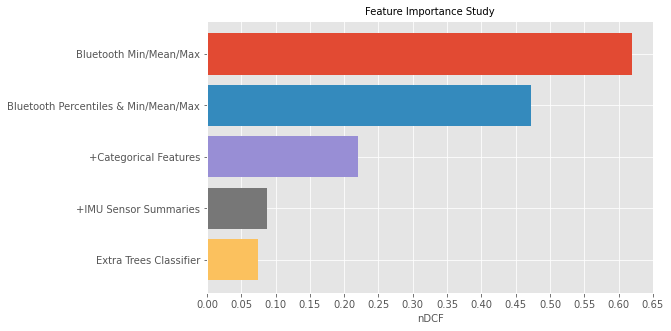

In [219]:
feature_scores = OrderedDict({
    'Bluetooth Min/Mean/Max': 0.619762595765736,
    'Bluetooth Percentiles & Min/Mean/Max': 0.4728934256678541,
    '+Categorical Features': 0.22036800220371328,
    '+IMU Sensor Summaries': 0.08822264981663216,
    'Extra Trees Classifier': 0.0741548757880778,
})

plt.figure(figsize=(8, 5))
for name, value in feature_scores.items():
    plt.barh(name, value)
plt.gca().invert_yaxis()
plt.title("Feature Importance Study", fontsize=10)
plt.xlabel("nDCF", fontsize=10)
plt.xticks(np.arange(0., 0.7, 0.05));
# plt.axvline(x=feature_scores["Extra Trees Classifier"], alpha=0.6, c="black")

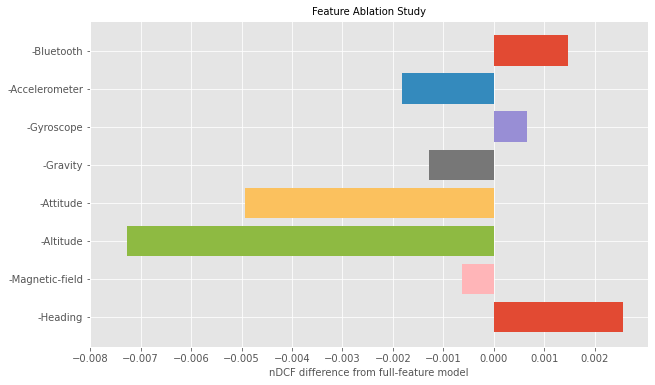

In [225]:
abl_feature_scores = OrderedDict({
     'All': 0.0741548757880778,
     '-Bluetooth': 0.0726848513919191,
     '-Accelerometer': 0.07598071849208757,
     '-Gyroscope': 0.07349310099794051,
     '-Gravity': 0.07544177827175808,
     '-Attitude': 0.07907816897918306,
     '-Altitude': 0.08142893993384989,
     '-Magnetic-field': 0.07478436489097895,
     '-Heading': 0.0715882224305514
})

plt.figure(figsize=(10, 6))
for name, value in abl_feature_scores.items():
    if name != "All":
        plt.barh(name, abl_feature_scores["All"] - value)
plt.gca().invert_yaxis()
plt.title("Feature Ablation Study", fontsize=10)
plt.xlabel("nDCF difference from full-feature model", fontsize=10)
plt.xticks(np.arange(-0.008, 0.003, 0.001));